Accuracy: 0.9789799607677219
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    103447
           1       0.20      0.96      0.32       549

    accuracy                           0.98    103996
   macro avg       0.60      0.97      0.66    103996
weighted avg       1.00      0.98      0.99    103996



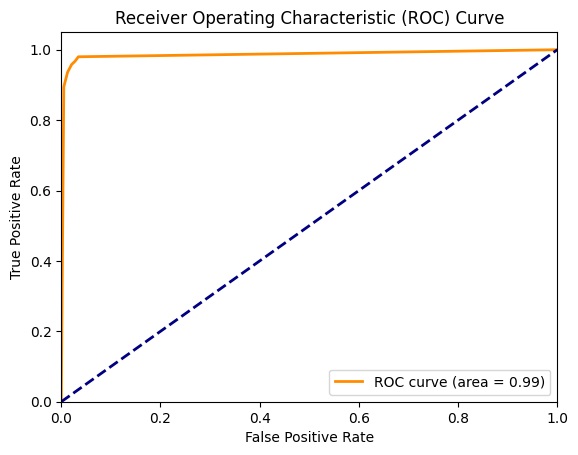

TF-IDF features saved to file: /Users/zhangguoyu/Downloads/tfidf_features.csv


In [3]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# Load phishing emails and normal emails data
phishing_file_path = '/Users/zhangguoyu/Downloads/CaptstoneProjectData_2024.csv'
phishing_data = pd.read_csv(phishing_file_path)

normal_file_path = '/Users/zhangguoyu/Downloads/emails.csv'
normal_data = pd.read_csv(normal_file_path)

# Fill missing values
phishing_data['Subject'] = phishing_data['Subject'].fillna('')
phishing_data['Body'] = phishing_data['Body'].fillna('')
normal_data['file'] = normal_data['file'].fillna('')
normal_data['message'] = normal_data['message'].fillna('')

# Simple text preprocessing function
def simple_preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    text = text.lower()
    text = text.replace('________________________________', '')
    words = text.split()
    stop_words = {
        'a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at',
        'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could',
        "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for',
        'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's",
        'her', 'here', "here's", 'hers', 'herself', 'him', "himself", 'his', 'how', "how's", 'I', "I'd", "I'll", "I'm",
        "I've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', 'let', "let's", 'me', 'more', 'most',
        "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our',
        'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should',
        "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 'then',
        'there', "there's", 'these', 'they', "they'd", "they'll", "they're", "they've", 'this', 'those', 'through', 'to',
        'too', 'under', 'until', 'up', 'very', 'was', "wasn't", 'we', "we'd", "we'll", "we're", "we've", 'were',
        "weren't", 'what', "what's", 'when', "when's", 'where', "where's", 'which', 'while', 'who', "who's", 'whom',
        'why', "why's", 'with', "won't", 'would', "wouldn't", 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours',
        'yourself', 'yourselves'
    }
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing function
phishing_data['Cleaned_Subject'] = phishing_data['Subject'].apply(simple_preprocess_text)
phishing_data['Cleaned_Body'] = phishing_data['Body'].apply(simple_preprocess_text)
normal_data['Cleaned_Subject'] = normal_data['file'].apply(simple_preprocess_text)
normal_data['Cleaned_Body'] = normal_data['message'].apply(simple_preprocess_text)

# Combine cleaned subject and body
phishing_data['Cleaned_Text'] = phishing_data['Cleaned_Subject'] + " " + phishing_data['Cleaned_Body']
normal_data['Cleaned_Text'] = normal_data['Cleaned_Subject'] + " " + normal_data['Cleaned_Body']

# Add labels
phishing_data['Label'] = 1
normal_data['Label'] = 0

# Combine datasets
all_emails = pd.concat([phishing_data, normal_data], ignore_index=True)

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Extract TF-IDF features
tfidf_matrix = tfidf_vectorizer.fit_transform(all_emails['Cleaned_Text'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['Label'] = all_emails['Label'].values

# Split the dataset
X = tfidf_df.drop('Label', axis=1)
y = tfidf_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train K-Nearest Neighbors classifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

# Calculate ROC curve and AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Save TF-IDF features to CSV file
output_file_path = '/Users/zhangguoyu/Downloads/tfidf_features.csv'
tfidf_df.to_csv(output_file_path, index=False)

print(f"TF-IDF features saved to file: {output_file_path}")